In [8]:
using Random
using Distributions
using Agents
using DataFrames
using Statistics
using Plots
using Measures

# -----------------------------
# Model / phase configuration
# -----------------------------

const EXTINCTION_MONTH  = 52.0
const PLATEAU_MONTH     = 10.5
const DECLINE_MONTH     = 18.5

const GENERATION_MONTHS = 3
const INITIAL_POPULATION = 8
const CARRYING_CAPACITY  = 3840
const TARGET_PEAK        = 2200      # just for your reference

# Base monthly rates (pre-phase adjustments)
const BASE_SURVIVAL_RATE = 0.95
const BASE_FECUNDITY     = 0.30      # conceptual intensity for reproduction

# Demography
const ADULTHOOD_MONTHS   = 2         # adults can reproduce after 3 months
const SEX_PROB_FEMALE    = 0.5

0.5

In [ ]:
#############################
# Rat Utopia ABM (Agents.jl)
#############################



# -----------------------------
# Uncertainty schedule (p -> u)
# -----------------------------

"""
p(t): piecewise schedule as in your matrix model
- Growth: p = 1/3
- Plateau: linear 1/3 -> 1/2
- Decline: 1/2 -> 1 (asymptotic)
"""
function calculate_gradual_p(month::Int)::Float64
    if month < PLATEAU_MONTH
        return 1.0/3.0
    elseif month < DECLINE_MONTH
        progress = (month - PLATEAU_MONTH) / (DECLINE_MONTH - PLATEAU_MONTH)
        return 1.0/3.0 + progress * (0.5 - 1.0/3.0)
    else
        excess = month - DECLINE_MONTH
        return 0.5 + 0.5 * (1.0 - exp(-0.25 * excess))
    end
end

"""
u = 1 - 1.5 (p - 1/3)  maps p ∈ {1/3, 1/2, 1} to u ∈ {1, 0.75, 0}
"""
calculate_uncertainty(p::Float64) = 1.0 - 1.5 * (p - 1.0/3.0)

phase(month::Int) = month < PLATEAU_MONTH ? :Growth :
                    month < DECLINE_MONTH ? :Plateau : :Decline

# -----------------------------
# Engagement (no payoff matrix)
# -----------------------------

"""
Map uncertainty u ∈ [0,1] to engagement propensity in [0,1].
Logistic is convenient and tunable. k controls steepness; u0 shifts midpoint.
High u -> near 1; u ~ 0.75 (plateau) -> moderate; u -> 0 (decline) -> near 0.
"""
function engagement_probability(u::Float64; k::Float64 = 6.0, u0::Float64 = 0.35)
    return clamp(1.0 / (1.0 + exp(-k * (u - u0))), 0.0, 1.0)
end

"""
Phase-dependent reproduction success probability per engaged pair,
and baseline survival multiplier, mirroring your piecewise monthly logic.
Returns (pair_success_prob, survival_base) for the month.
"""
function phase_rates(month::Int)
    if month < PLATEAU_MONTH
        # Growth: strong fecundity and slightly higher survival
        pair_success = 0.635           # per adult-female conception chance given >=1 male
        survival     = 0.97
        litter_mean  = 6.0
        return (pair_success, survival, litter_mean)
    elseif month < DECLINE_MONTH
        # Plateau: still positive growth but slower (creeps toward ~2k)
        pair_success = 0.20
        survival     = BASE_SURVIVAL_RATE * 0.98   # 0.931
        litter_mean  = 4.0
        return (pair_success, survival, litter_mean)
    else
        # Decline: keep your extinction shape; births & survival taper
        decline_progress = min(1.0, (month - DECLINE_MONTH) / (EXTINCTION_MONTH - DECLINE_MONTH))
        decline_accel    = decline_progress^5
        pair_success = clamp(0.22 - 0.20 * decline_accel, 0.0, 1.0)
        survival     = clamp(BASE_SURVIVAL_RATE * (0.98 - 0.38 * decline_accel), 0.01, 0.99)
        litter_mean  = max(1.2 - 0.9 * decline_progress, 0.3)
        return (pair_success, survival, litter_mean)
    end
end



"""
Overcrowding factors when N > 0.9K, similar to your penalties:
- reproduction success reduced (quadratic)
- survival reduced (gentle)
Returns (repr_mult, surv_mult)
"""
function crowding_factors(n::Int, K::Int)
    if n <= 0.9 * K
        return (1.0, 1.0)
    else
        factor = (0.9 * K) / n
        repr_mult = factor^2
        surv_mult = 0.5 + 0.5 * factor
        return (repr_mult, surv_mult)
    end
end

# -----------------------------
# Rank dynamics
# -----------------------------

const RANKS = (:dominant, :intermediate, :subordinate)

"""
Uncertainty-dependent rank mobility:
- High u (growth): upward mobility more likely
- Plateau: small bidirectional noise
- Decline: more rigidity + downward drift
"""
# function update_rank!(rk::Symbol, u::Float64, ph::Symbol, rng::AbstractRNG)
#     r = rand(rng)
#     if ph == :Growth
#         if rk == :subordinate && r < 0.05 + 0.10*u
#             return :intermediate
#         elseif rk == :intermediate && r < 0.03 + 0.07*u
#             return :dominant
#         else
#             return rk
#         end
#     elseif ph == :Plateau
#         # Small, roughly symmetric perturbations
#         if rk == :subordinate && r < 0.02
#             return :intermediate
#         elseif rk == :intermediate
#             return r < 0.015 ? :dominant : (r > 0.985 ? :subordinate : :intermediate)
#         elseif rk == :dominant && r > 0.985
#             return :intermediate
#         else
#             return rk
#         end
#     else # :Decline
#         if rk == :dominant && r < 0.05*(1.0 - u + 0.2)
#             return :intermediate
#         elseif rk == :intermediate && r < 0.07*(1.0 - u + 0.2)
#             return :subordinate
#         else
#             return rk
#         end
#     end
# end
function update_rank!(rk::Symbol, u::Float64, ph::Symbol, rng::AbstractRNG)
    r = rand(rng)
    if ph == :Growth
        # Strong upward mobility when u is high
        if rk == :subordinate && r < (0.12 + 0.20*u)     # <= 0.32 at u=1
            return :intermediate
        elseif rk == :intermediate && r < (0.06 + 0.12*u) # <= 0.18 at u=1
            return :dominant
        else
            return rk
        end

    elseif ph == :Plateau
        # Mild upward mobility persists; demotions still rare
        if rk == :subordinate && r < 0.03
            return :intermediate
        elseif rk == :intermediate
            return r < 0.025 ? :dominant : (r > 0.992 ? :subordinate : :intermediate)
        elseif rk == :dominant && r > 0.996
            return :intermediate
        else
            return rk
        end

    else # :Decline
        # Rigidity + downward drift
        if rk == :dominant && r < 0.05*(1.0 - u + 0.2)
            return :intermediate
        elseif rk == :intermediate && r < 0.07*(1.0 - u + 0.2)
            return :subordinate
        else
            return rk
        end
    end
end

# -----------------------------
# Agents.jl definitions
# -----------------------------

# Fixed agent definition using mutable struct
mutable struct RatAgent <: AbstractAgent
    id::Int
    pos::Tuple{Int,Int}
    sex::Symbol                 # :male or :female
    age_months::Int
    rank::Symbol                # :dominant, :intermediate, :subordinate
    propensity::Float64         # engagement propensity this month
    engaging::Bool              # whether the rat attempts engagement this month
    alive::Bool
    beautiful_one::Bool         # late-decline low-engagement subtype
end

# Helper: create newborn (fetch RNG safely from the model)
function newborn!(model)
    rng   = getfield(model, :rng)
    props = getfield(model, :properties)
    month = props[:month]
    ph    = phase(month)
    u     = calculate_uncertainty(calculate_gradual_p(month))

    pos = (1, 1)
    sex = rand(rng) < SEX_PROB_FEMALE ? :female : :male
    rnk = draw_newborn_rank(u, ph, rng)  # <-- use the new rank sampler

    add_agent!(pos, RatAgent, model, sex, 0, rnk, 0.0, false, true, false)
end
function draw_newborn_rank(u::Float64, ph::Symbol, rng::AbstractRNG)::Symbol
    # Smooth mapping: at u=1 -> (dom≈0.15, int≈0.55, sub≈0.30)
    #                 at u=0 -> (dom≈0.05, int≈0.25, sub≈0.70)
    p_sub = clamp(0.70 - 0.40*u, 0.20, 0.80)
    p_dom = clamp(0.05 + 0.10*u, 0.02, 0.20)
    p_int = 1.0 - p_sub - p_dom
    r = rand(rng)
    return r < p_dom ? :dominant : (r < p_dom + p_int ? :intermediate : :subordinate)
end


# -----------------------------
# Model step logic
# -----------------------------

"""
agent_step!: age, possibly die, set propensity, decide engagement, and update rank.
Reproduction is handled in model_step! (after we know who survived and engaged).
"""
function agent_step!(a::RatAgent, model::ABM)
    rng   = getfield(model, :rng)
    props = getfield(model, :properties)
    month = props[:month]
    # Compute uncertainty and phase locally from month
    p = calculate_gradual_p(month)
    u = calculate_uncertainty(p)
    ph = phase(month)

    # Age advance
    a.age_months += 1
    if !a.alive
        return
    end

    # Base survival for this month (phase), then apply crowding and modifiers
    (_, survival_base, _) = phase_rates(month)
    n = nagents(model)
    K = model.carrying_capacity
    (_, surv_mult) = crowding_factors(n, K)

    survival = clamp(survival_base * surv_mult, 0.01, 0.999)

    # Age modifier: simple senescence after 24 months, mild infant risk
    if a.age_months < 2
        survival *= 0.98
    elseif a.age_months > 24
        survival *= max(0.7, 1.0 - 0.01 * (a.age_months - 24))
    end

    # Rank stress: subordinates slightly worse in decline
    if ph == :Decline && a.rank == :subordinate
        survival *= 0.96
    end

    # Death sampling
    if rand(rng) > survival
        a.alive = false
        remove_agent!(a, model)
        model.deaths_in_month += 1
        return
    end

    # Engagement propensity and decision (no game matrix)
    base_prop = engagement_probability(u)
    # Rank modulation: intermediate ~0, dominant slight boost, subordinate slight drop
    rank_mult = a.rank == :dominant ? 1.05 : (a.rank == :subordinate ? 0.95 : 1.0)
    a.propensity = clamp(base_prop * rank_mult, 0.0, 1.0)
    a.engaging = rand(rng) < a.propensity

    # "Beautiful ones": late-decline, subordinate, persistently low engagement
    if ph == :Decline && u < 0.2 && a.rank == :subordinate && a.propensity < 0.2
        a.beautiful_one = true
    end

    # Rank mobility
    a.rank = update_rank!(a.rank, u, ph, rng)
end

"""
model_step!: pair engaged adults, attempt reproduction with crowding-adj. success,
add newborns, record monthly statistics, and advance month.
"""
function model_step!(model::ABM)
    rng   = getfield(model, :rng)
    props = getfield(model, :properties)
    month = props[:month]
    n = nagents(model)
    model.births_in_month = 0
    # Simply initialize deaths_in_month to 0 at start of each step
    model.deaths_in_month = 0

    # Compute uncertainty/phase for records and for reproduction calibration
    p = calculate_gradual_p(month)
    u = calculate_uncertainty(p)
    ph = phase(month)

    # Phase rates + crowding adjust reproduction success
    (pair_success, _, litter_mean) = phase_rates(month)
    (repr_mult, _) = crowding_factors(n, props[:carrying_capacity])
    pair_success = clamp(pair_success * repr_mult, 0.0, 1.0)

    # Collect engaged, adult males and females
    males   = RatAgent[]
    females = RatAgent[]
    for a in allagents(model)
        if a.alive && a.engaging && a.age_months >= ADULTHOOD_MONTHS
            if a.sex == :male
                push!(males, a)
            else
                push!(females, a)
            end
        end
    end

    # Random pairing
    shuffle!(rng, males)
    shuffle!(rng, females)
    num_pairs = min(length(males), length(females))

    # Litter size distribution varies slightly by phase
    litter_mean = ph == :Growth ? 3.0 : ph == :Plateau ? 2.0 : 1.0
    litter_dist = Poisson(max(litter_mean, 0.0))

    for i in 1:num_pairs
        if rand(rng) < pair_success
            litter = rand(rng, litter_dist)
            # ensure at least 1 in growth/plateau to keep momentum
            if (ph != :Decline) && litter == 0
                litter = 1
            end
            for _ in 1:litter
                newborn!(model)
                model.births_in_month += 1
            end
        end
    end

    # Compute monthly aggregates
    N = nagents(model)
    mean_propensity = N == 0 ? 0.0 : mean(a -> a.propensity, allagents(model))
    dom = count(a -> a.rank == :dominant, allagents(model))
    mid = count(a -> a.rank == :intermediate, allagents(model))
    sub = count(a -> a.rank == :subordinate, allagents(model))
    beautiful_prop = N == 0 ? 0.0 : count(a -> a.beautiful_one, allagents(model)) / N

    # Record
    push!(model.history, (
        month = month,
        p = p,
        u = u,
        phase = String(ph),
        population = N,
        births = model.births_in_month,
        deaths = model.deaths_in_month,
        mean_propensity = mean_propensity,
        dominant = dom,
        intermediate = mid,
        subordinate = sub,
        beautiful_ones_prop = beautiful_prop,
        pair_success_prob = pair_success
    ))

    # Reset per-month counters and advance month
    model.deaths_in_month = 0
    model.month = month + 1
end

# -----------------------------
# Initialization and runner
# -----------------------------

function initialize_model(; seed::Int = 42,
    initial_population::Int = INITIAL_POPULATION,
    carrying_capacity::Int = CARRYING_CAPACITY)

    rng_local = MersenneTwister(seed)
    space = GridSpace((1, 1); periodic = false)

    # Create model with properties as direct fields - updated for Agents.jl v6
    properties = Dict(
        :month => 0,
        :carrying_capacity => carrying_capacity,
        :history => NamedTuple[],
        :deaths_in_month => 0,
        :births_in_month => 0,
        :maxid => initial_population  # Store maxid in properties
    )

    model = ABM(RatAgent, space; 
                rng = rng_local,
                scheduler = Schedulers.Randomly(),
                properties = properties,
                agent_step! = agent_step!,
                model_step! = model_step!)

    # Seed initial population with a balanced rank mix leaning intermediate
    for i in 1:initial_population
        pos = (1, 1)
        sex = rand(rng_local) < SEX_PROB_FEMALE ? :female : :male
        rank = (:intermediate, :subordinate, :dominant)[rand(rng_local, 1:3)]
        
        agent = RatAgent(
            i,              # id
            pos,            # position
            sex,            # sex
            6,              # age_months (start as adults)
            rank,           # rank
            0.0,            # propensity
            false,          # engaging
            true,           # alive
            false           # beautiful_one
        )
        add_agent!(agent, model)
    end

    return model
end

function run_abm!(model; max_months::Int = 60)
    for _ in 1:max_months
        step!(model, agent_step!, model_step!, 1)
        if nagents(model) == 0
            break
        end
    end
    props = getfield(model, :properties)
    return DataFrame(props[:history])
end

# -----------------------------
# Visualization (4-panel)
# -----------------------------

# -----------------------------
# Visualization (ABM, 4-panel like matrix version)
# -----------------------------
function create_rat_plots_abm(df::DataFrame;
    plateau_month::Real   = PLATEAU_MONTH,
    decline_month::Real   = DECLINE_MONTH,
    extinction_month::Real = EXTINCTION_MONTH)

    months         = df.month
    populations    = df.population
    uncertainties  = df.u
    engager_props  = df.mean_propensity   # ABM analogue of "x" (engagement proportion)

    dominant       = df.dominant
    intermediate   = df.intermediate
    subordinate    = df.subordinate

    # ---------------- Panel 1: Population (linear) ----------------
    p1 = plot(months, populations;
              linewidth=4, color=:red, marker=:circle, markersize=3,
              title="Population Dynamics",
              xlabel="Month", ylabel="Population",
              legend=false, grid=true)

    vspan!(p1, [0, plateau_month-1];                 alpha=0.15, color=:green, label="Growth")
    vspan!(p1, [plateau_month, decline_month];       alpha=0.20, color=:blue,  label="Plateau")
    vspan!(p1, [decline_month+1, maximum(months)];   alpha=0.15, color=:red,   label="Decline")

    max_pop = maximum(populations)
    annotate!(p1, plateau_month/2, max_pop*0.9, text("Growth", 10, :center))
    annotate!(p1, plateau_month+(decline_month-plateau_month)/2, max_pop*0.9, text("Plateau", 10, :center))
    annotate!(p1, decline_month+10, max_pop*0.9, text("Decline", 10, :center))

    # ---------------- Panel 2: Population (semi-log) --------------
last_pos = findlast(>(0), populations)
if last_pos === nothing
    last_pos = length(populations)
else
    last_pos = Int(last_pos)
end
months_log = months[1:last_pos]
pops_log   = populations[1:last_pos]
minpos     = minimum(pops_log)
ylow       = min(0.1, minpos/2)

p2 = plot(months_log, pops_log;
          linewidth=3, color=:darkred, marker=:circle, markersize=3,
          title="Population (Semi-Log Scale)",
          xlabel="Month", ylabel="Population (log scale)",
          legend=false, grid=true, yscale=:log10, ylims=(ylow, maximum(populations)*2))

    vspan!(p2, [0, plateau_month-1];               alpha=0.15, color=:green)
    vspan!(p2, [plateau_month, decline_month];     alpha=0.20, color=:blue)
    vspan!(p2, [decline_month+1, maximum(months)]; alpha=0.15, color=:red)

    max_pop_log = maximum(populations)
    annotate!(p2, plateau_month/2, max_pop_log*0.9, text("Growth", 10, :center))
    annotate!(p2, plateau_month+(decline_month-plateau_month)/2, max_pop_log*0.9, text("Plateau", 10, :center))
    annotate!(p2, decline_month+13, max_pop_log*0.9, text("Decline", 10, :center))

    # ---------------- Panel 3: Social Stratification --------------
    p3 = plot(months, dominant;
              linewidth=3, color=:orange, marker=:square, markersize=3,
              label="Dominant",
              title="Social Stratification",
              xlabel="Month", ylabel="Population by Stratum",
              grid=true, legend=:topright)
    plot!(p3, months, intermediate; linewidth=3, color=:blue,   marker=:diamond, markersize=3, label="Intermediate")
    plot!(p3, months, subordinate;  linewidth=3, color=:purple, marker=:circle,  markersize=3, label="Subordinate")

    vspan!(p3, [0, plateau_month-1];               alpha=0.10, color=:green, label="")
    vspan!(p3, [plateau_month, decline_month];     alpha=0.15, color=:blue,  label="")
    vspan!(p3, [decline_month+1, maximum(months)]; alpha=0.10, color=:red,   label="")

    max_strat = maximum(vcat(dominant, intermediate, subordinate))
    annotate!(p3, plateau_month/2, max_strat*0.9, text("Growth", 10, :center))
    annotate!(p3, plateau_month+(decline_month-plateau_month)/2, max_strat*0.9, text("Plateau", 10, :center))
    annotate!(p3, decline_month+17, max_strat*0.9, text("Decline", 10, :center))

    # ---------------- Panel 4: Uncertainty & Engagement ----------
    # keep the same "paradigm" (add ln lines and a 1.2 cap so they show)
    ymax = max(maximum(uncertainties), 1.2)
    p4 = plot(months, uncertainties;
              linewidth=3, color=:purple, marker=:diamond, markersize=4,
              label="Uncertainty (u)",
              title="Uncertainty and Engagement Evolution",
              xlabel="Month", ylabel="Value", grid=true, ylims=(0, ymax),
              legend=:topright)

    plot!(p4, months, engager_props;
          linewidth=3, color=:blue, marker=:circle, markersize=4,
          label="Engagement Proportion")

    hline!(p4, [log(3)]; linestyle=:dash, color=:green,  alpha=0.7, label="ln(3)")
    hline!(p4, [log(2)]; linestyle=:dash, color=:orange, alpha=0.7, label="ln(2)")
    hline!(p4, [0.0];    linestyle=:dash, color=:red,    alpha=0.7, label="Zero")

    vspan!(p4, [0, plateau_month-1];               alpha=0.10, color=:green, label="")
    vspan!(p4, [plateau_month, decline_month];     alpha=0.15, color=:blue,  label="")
    vspan!(p4, [decline_month+1, maximum(months)]; alpha=0.10, color=:red,   label="")

    annotate!(p4, plateau_month/2, ymax*0.7, text("Growth", 10, :center))
    annotate!(p4, plateau_month+(decline_month-plateau_month)/2, ymax*0.7, text("Plateau", 10, :center))
    annotate!(p4, decline_month+11, ymax*0.7, text("Decline", 10, :center))

    return plot(p1, p2, p3, p4; layout=(2,2), size=(1200,900),
                margin=5mm, plot_title="Rat Utopia (ABM)")
end


# -----------------------------
# Main
# -----------------------------

function main()
    println("Initializing model...")
    model = initialize_model(seed=42, initial_population=INITIAL_POPULATION,
                             carrying_capacity=CARRYING_CAPACITY)
    println("Running simulation...")
    df = run_abm!(model; max_months=60)
    println("Simulation completed!")
    println("Final population: ", df.population[end])
    println("Total months simulated: ", length(df.month))
    
    println("Creating plots...")
    plt = create_rat_plots_abm(df)
    savefig(plt, "rat_utopia_abm.png")
    savefig(plt, "rat_utopia_abm.pdf")
    println("Plot saved as rat_utopia_abm.png")
    
    return df, plt
end

# Uncomment to run directly
# df, plt = main()



main (generic function with 1 method)

Initializing model...
Running simulation...
Simulation completed!
Final population: 0
Total months simulated: 57
Creating plots...
Plot saved as rat_utopia_abm.png


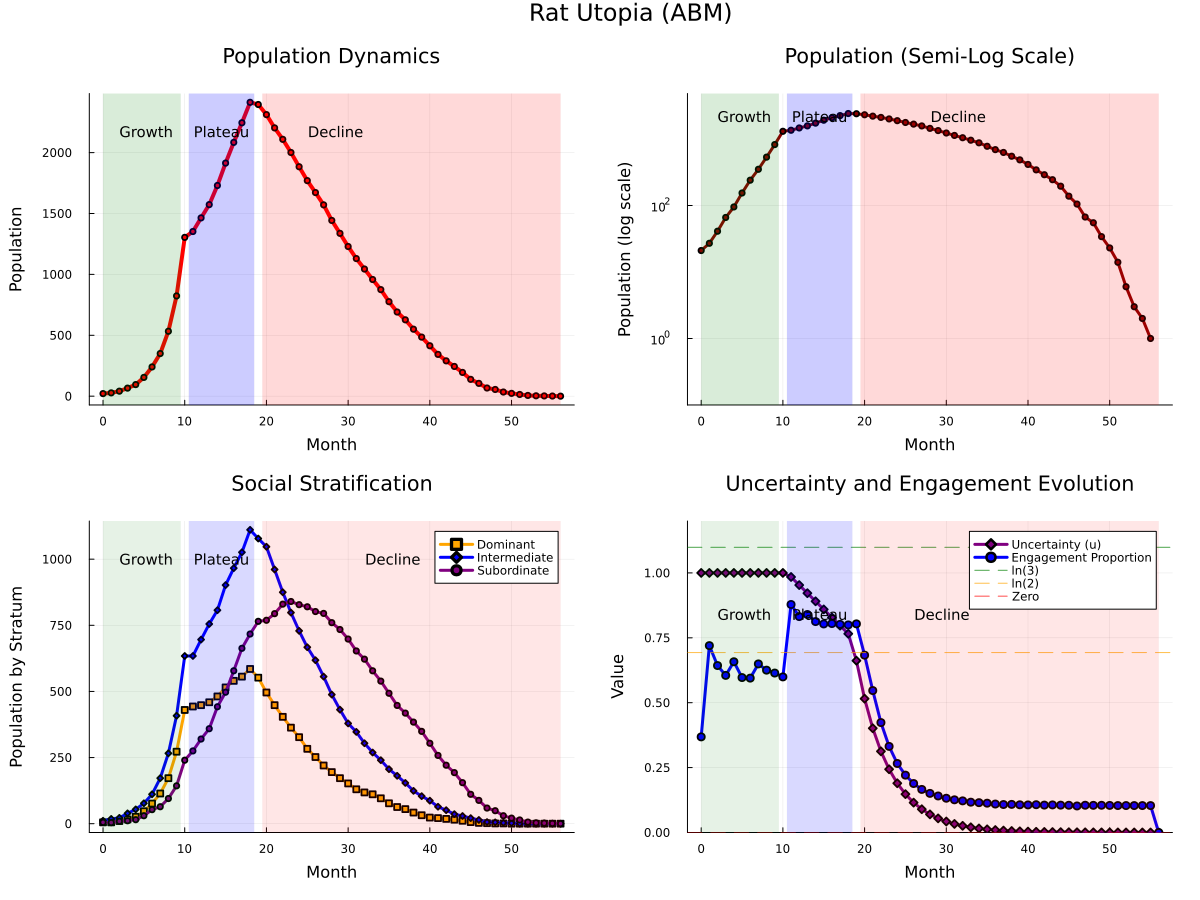

In [52]:
df, plt = main()

display(plt)